Utilities for collecting fitting results and generating plots of equivalent ICESat-2 profiles are in the make_composite_stats module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from make_composite_stats import setup, composite_stats, make_composite_wf
catalog=setup('SRF_green_full.h5', 'TEP.h5')
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import pointCollection as pc
import glob
import os
import h5py

MOA_125_file='/Volumes/ice1/ben/MOA/2009/moa125_2009_hp1_v1.1.tif'
MOA_1km_file='/Volumes/ice1/ben/MOA/2009/moa1km_2009_hp1_v1.1.tif'
data_dir='/Volumes/ice2/ben/ATM_WF/AA_18/fits/'


<IPython.core.display.Javascript object>


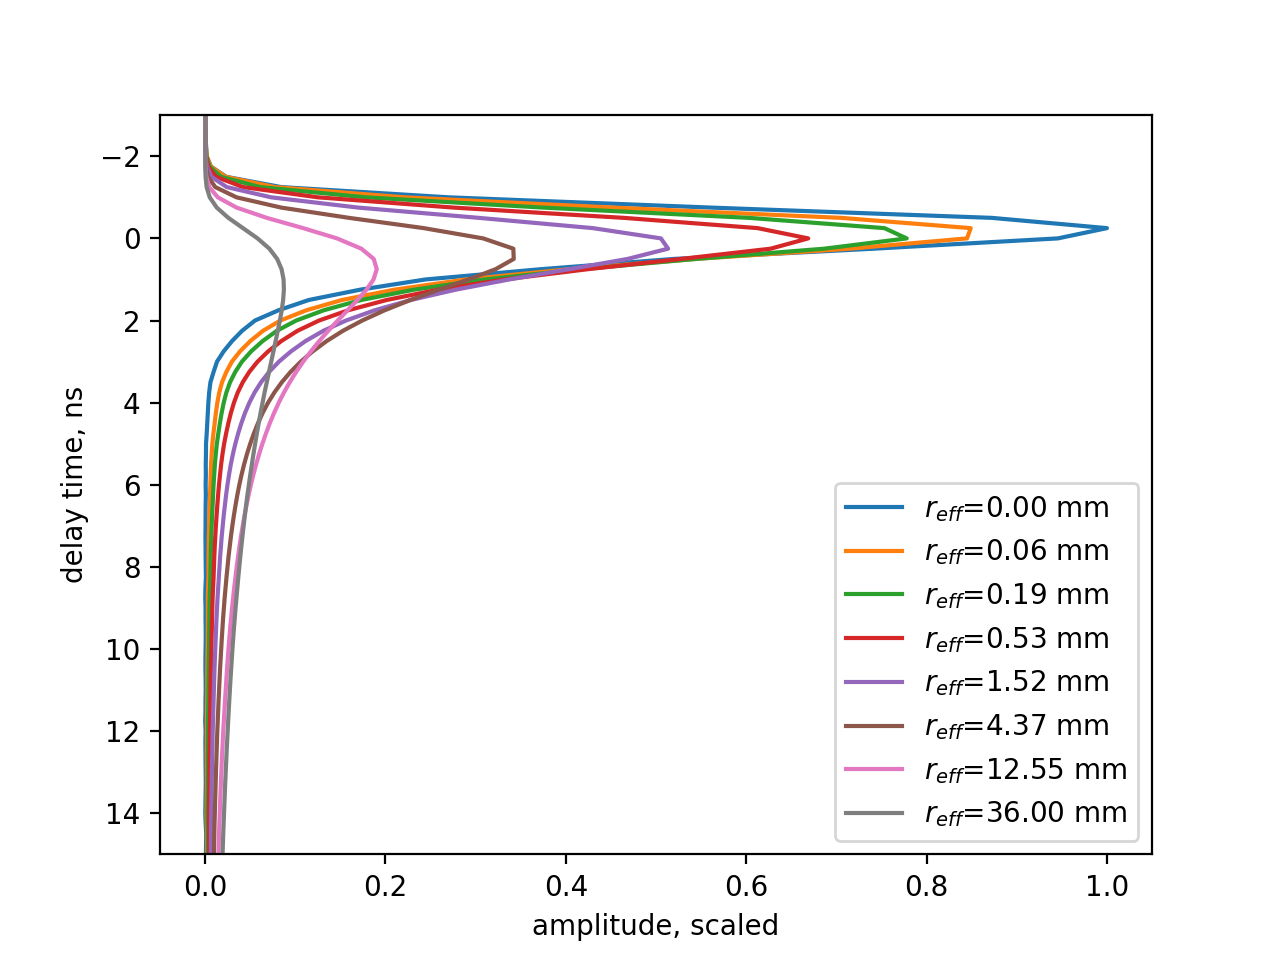

In [3]:
plt.figure(1); plt.clf()
for k0 in list(catalog)[::10]:
    plt.plot(catalog[k0].p, catalog[k0].t, label="$r_{eff}$=%4.2f mm" %(k0*1000.))
plt.gca().set_ylim([15, -3])
plt.legend()
plt.ylabel('delay time, ns')
plt.xlabel('amplitude, scaled')
plt.savefig('WF_scattering.pdf',format='pdf')

These correspond to window delays for a $\pm$ 1.5 m window for the median and mean:


<IPython.core.display.Javascript object>


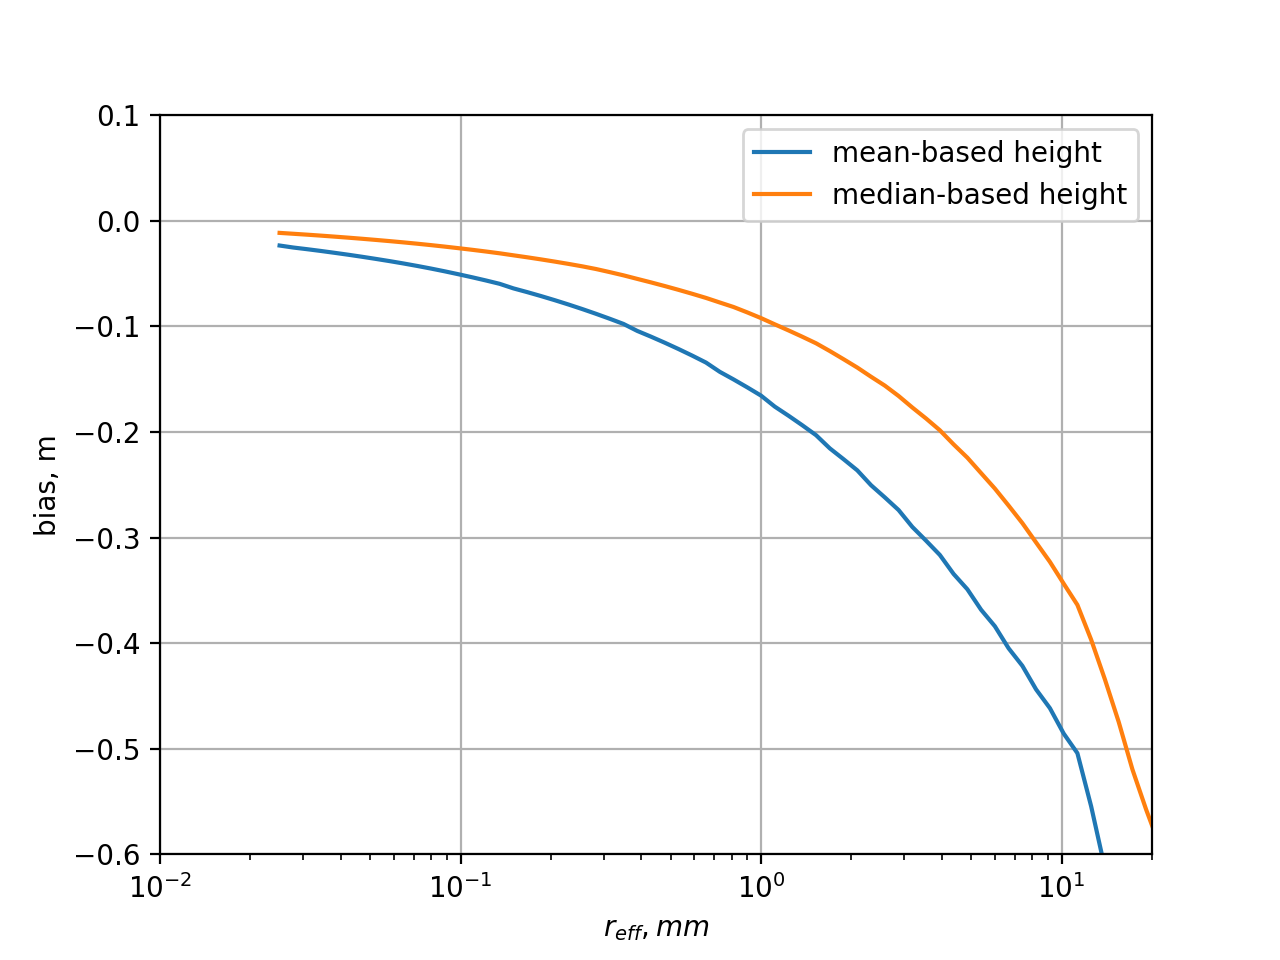

In [4]:
k0s=np.array(list(catalog))
means=np.array([composite_stats(catalog[k0], 20)[0] for k0 in k0s])
meds=np.array([composite_stats(catalog[k0], 20)[1] for k0 in k0s])

plt.figure(2); plt.clf()
plt.semilogx(k0s[1:]*1000, (means[1:]-means[0])*-.15, label='mean-based height')
plt.semilogx(k0s[1:]*1000, (meds[1:]-meds[0])*-.15, label='median-based height')
plt.grid()
plt.legend()
plt.gca().set_xlim([0.01, 20])
plt.gca().set_ylim([-0.6, 0.1])
plt.xlabel('$r_{eff}, mm$'); plt.ylabel('bias, m')
plt.savefig('bias_of_reff.pdf', format='pdf')

Spread on the recovered $r_{eff}$ values doesn't seem to bias the recovered delay.  Estimated fitting errors are OTO a factor of 2, or about 6 bins.  A quick simulation yields about the same delay values for a single waveform as for the composite of 400 waveforms with $r_{eff}$ values distributed by factor of 2 around the $r_{eff}$ for the single waveform:

<IPython.core.display.Javascript object>


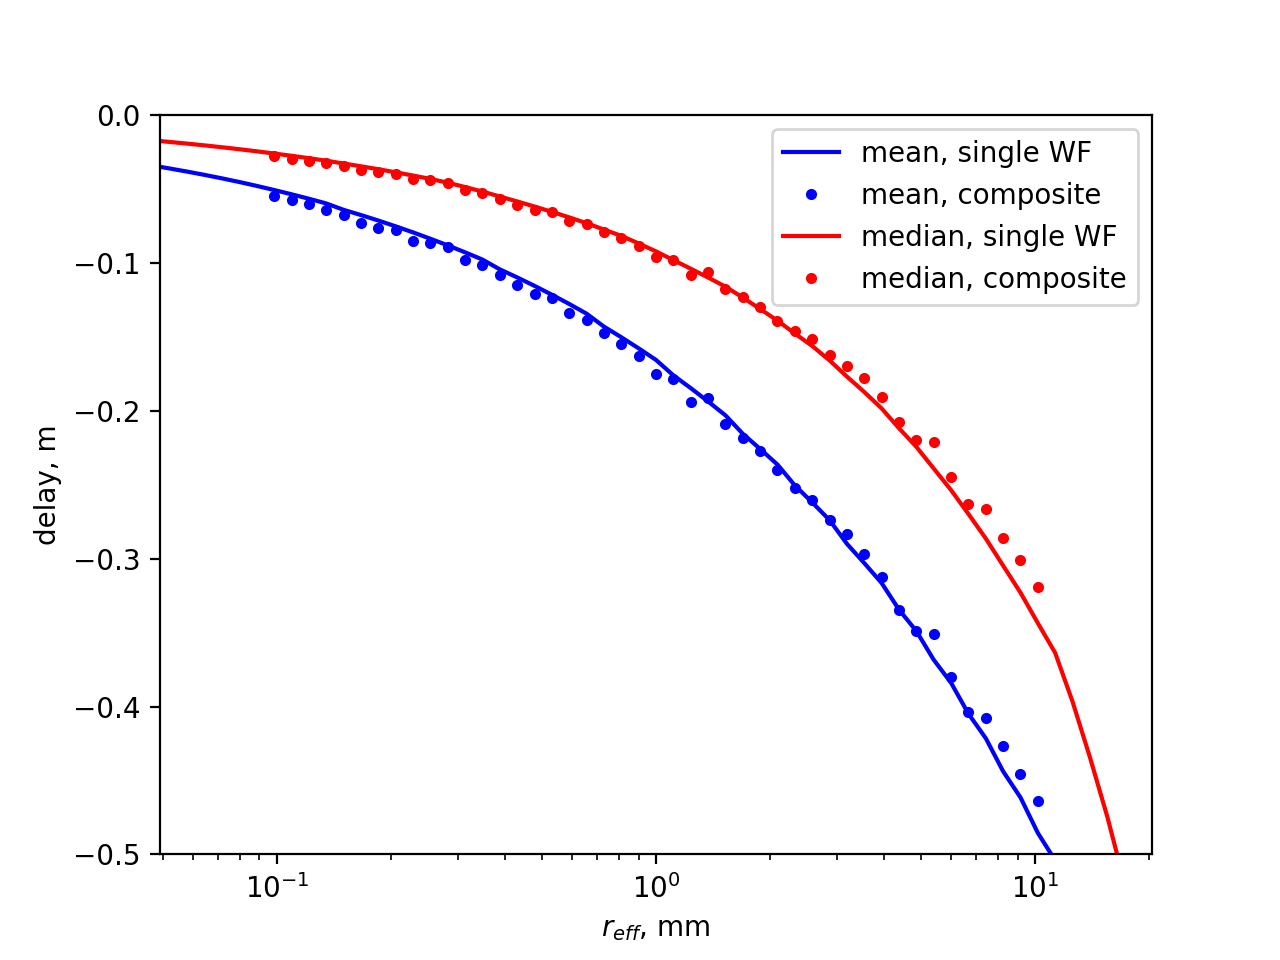

(-0.5, 0)

In [5]:
# a fitting error of a factor of 2 is equal to 6 bins, so start the calculation at bin 13 (2 sigma)
ind_vals=np.arange(14, len(k0s)-13)
dist_errors={field:np.zeros_like(ind_vals)+np.NaN for field in ['k0_med','k0_mean', 'k0_med_out','k0_mean_out']}

for count, ind in enumerate(ind_vals):
    k0_dist=k0s[ind] * 10**(np.log10(2)*np.random.randn(400))
    k0_dist = k0_dist[(k0_dist >= k0s[1]) & (k0_dist <= k0s[-1])]
    wf_composite = make_composite_wf(k0_dist, catalog)[0]
    dist_errors['k0_med'][count]=np.median(k0_dist)
    dist_errors['k0_mean'][count]=np.mean(k0_dist)
    dist_errors['k0_mean_out'][count], dist_errors['k0_med_out'][count] = composite_stats(wf_composite, 20)[0:2]
plt.figure()
plt.semilogx(k0s[1:]*1000, (means[1:]-means[0])*-.15,'b', label='mean, single WF')
#plt.semilogx(dist_errors['k0_med']*1000, (dist_errors['k0_mean_out']-means[0])*-.15,'b.', label='mean, composite')
plt.semilogx(k0s[ind_vals]*1000, (dist_errors['k0_mean_out']-means[0])*-.15,'b.', label='mean, composite')

plt.semilogx(k0s[1:]*1000, (meds[1:]-meds[0])*-.15,'r', label='median, single WF')
#plt.semilogx(dist_errors['k0_med']*1000, (dist_errors['k0_med_out']-meds[0])*-.15,'r.', label='median, composite')
plt.semilogx(k0s[ind_vals]*1000, (dist_errors['k0_med_out']-meds[0])*-.15,'r.', label='median, composite')

plt.legend()
plt.ylabel('delay, m')
plt.xlabel('$r_{eff}$, mm')
plt.gca().set_xlim([500*k0s[ind_vals[0]], 2000*k0s[ind_vals[-1]]])
plt.gca().set_ylim([-0.5, 0])

Note that this correspondence only works when plotting the composite-waveform delay against the median of the input $r_{eff}$ distribution or the actual center of the input distribution.  Plotting against the mean of the distribution shows that the mean $r_{eff}$ value tends to be significantly larger than the median or the parent-distribution center.

## Composite statistics for the Antarctic surveys

<IPython.core.display.Javascript object>


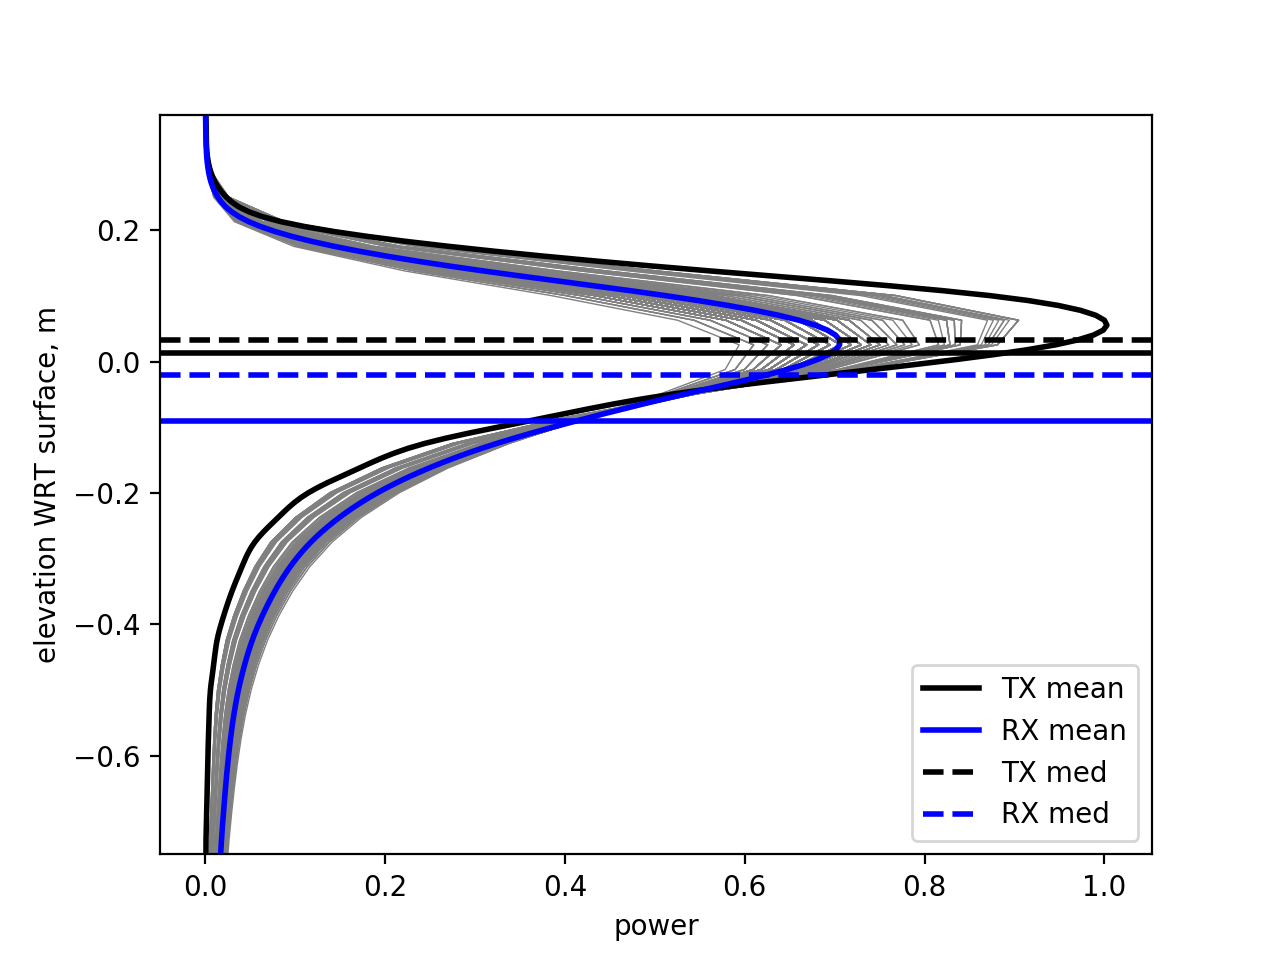

(-0.75, 0.375)

In [6]:
from make_composite_stats import make_plot
make_plot(data_dir+'2018.11.10/ILNSAW1B_20181110_181100.atm6DT7.h5_q4_out.h5', 'SRF_green_full.h5' ,'TEP.h5', res=40, t_window=20, xy0=[-511599.5, 302234.5])
plt.gca().set_ylim([-0.75, 0.375])

In [7]:

field_dict={None:['x','y','t_ctr','t_med','t_sigma','z_sigma']}
D=[]
files=glob.glob(os.path.join(data_dir, 'composite_stats/2*/*.h5'))
for file_count, file in enumerate(files):
    
    temp=pc.data().from_h5(file, field_dict=field_dict)
    temp.assign({'file_number':np.zeros_like(temp.t_med)+file_count})
    D += [temp]

with h5py.File(file,'r') as ff:
    t_tx_med=ff.attrs['tx_median']
    t_tx_mean=ff.attrs['tx_mean']
    
D=pc.data().from_list(D)
D.index(np.isfinite(D.x+D.y+D.t_ctr))
MOA_1km=pc.grid.data().from_geotif(MOA_1km_file, \
            bounds=[(np.min(D.x)-1.e5, np.max(D.x)+1.e5), (np.min(D.y)-1.e5, np.max(D.y)+1.e5)])

<IPython.core.display.Javascript object>


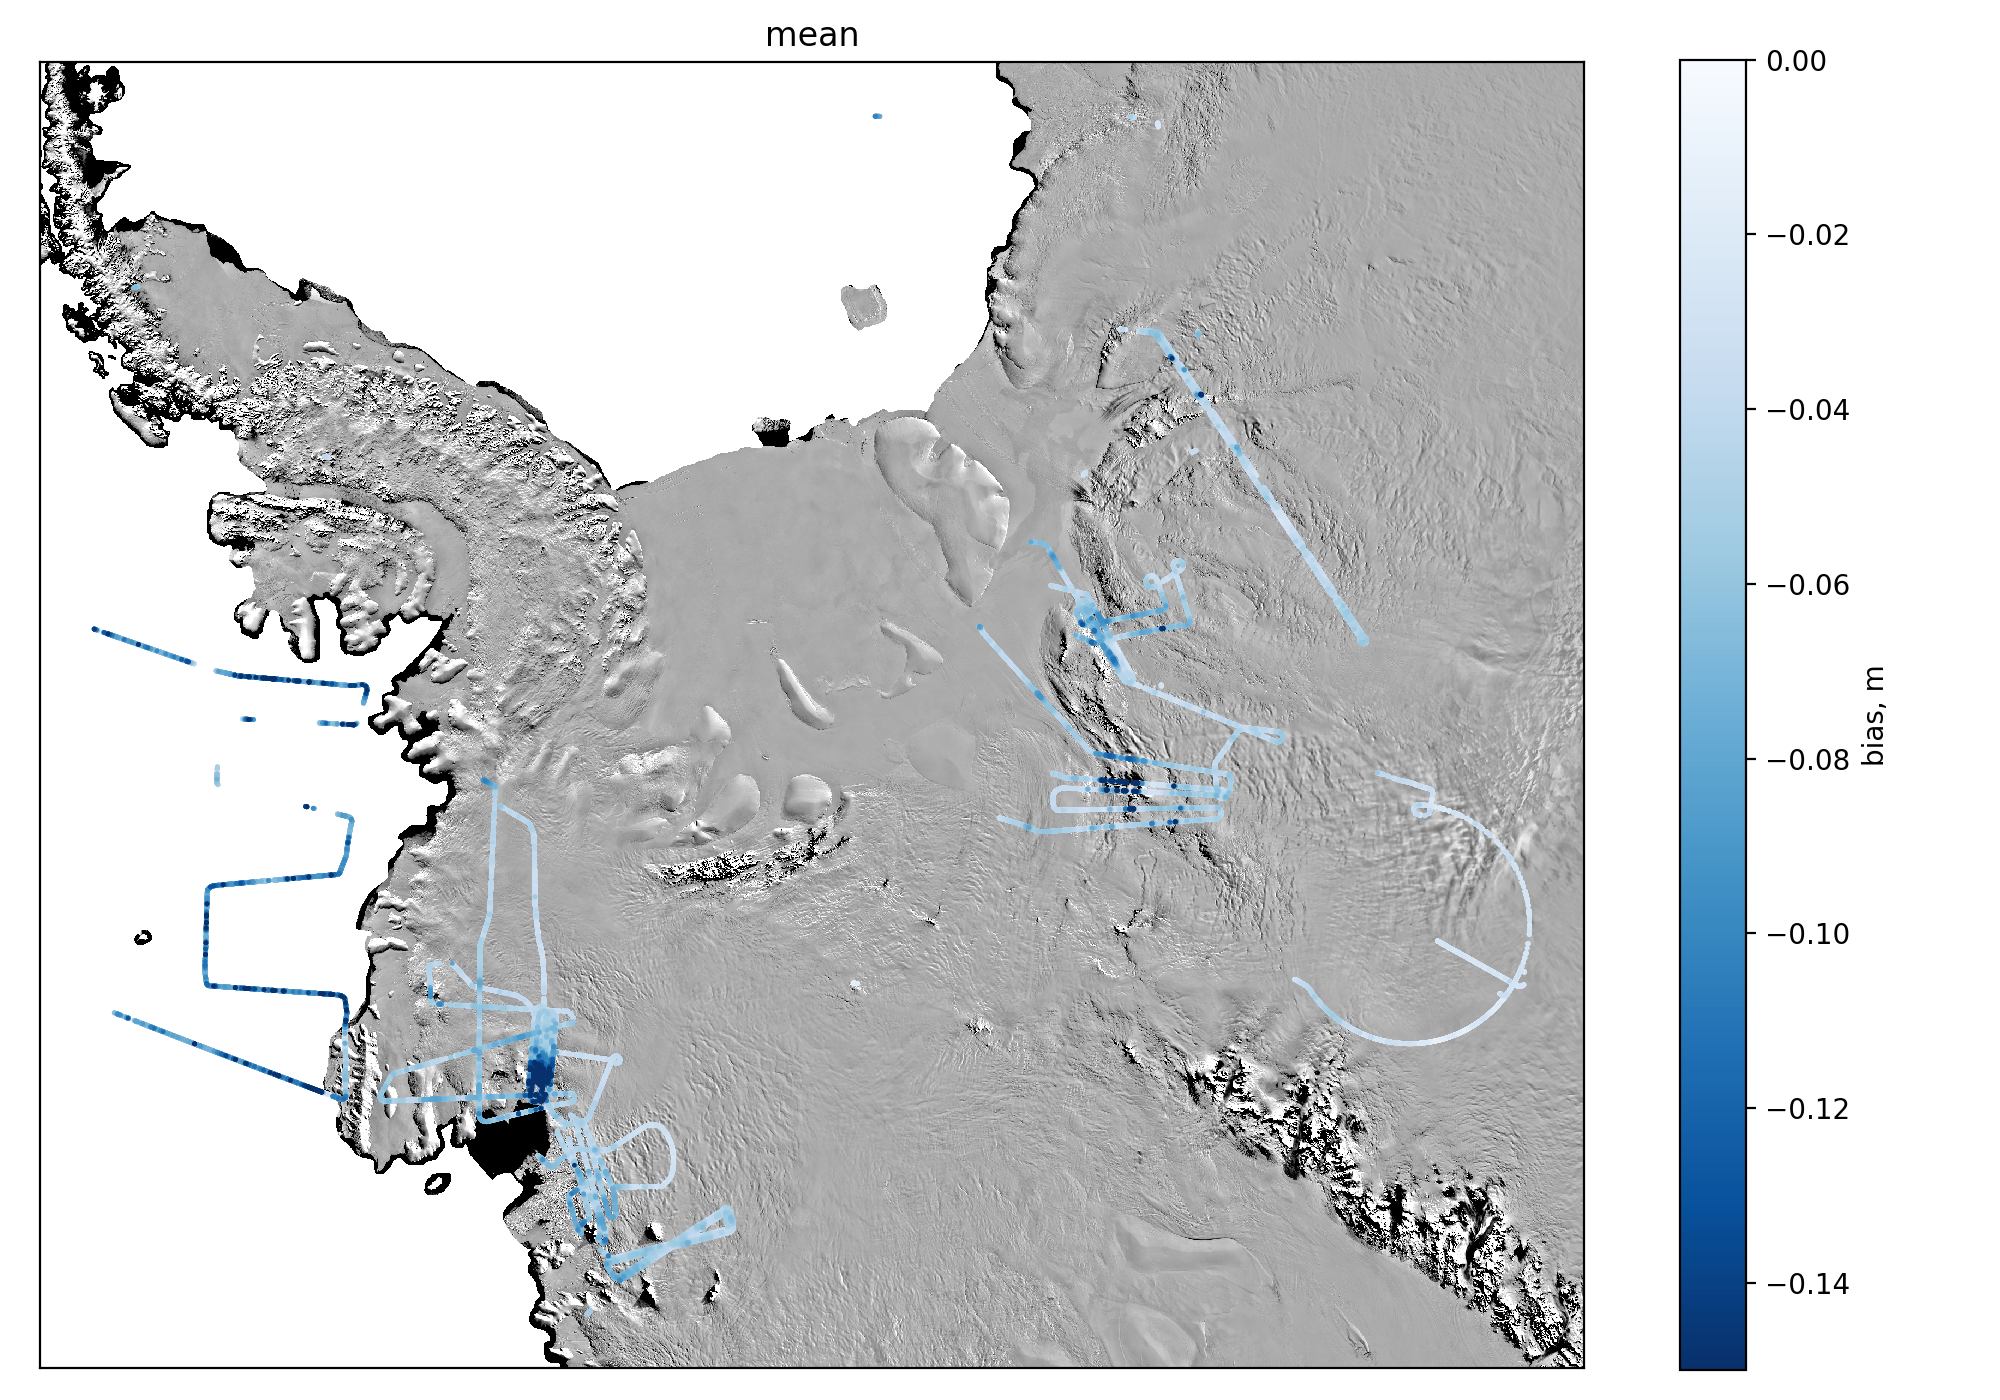

{'clim': [14000, 17000], 'cmap': 'gray', 'extent': array([-2511950.,   319050.,  -813175.,  1579825.]), 'origin': 'lower'}


In [8]:
plt.figure(figsize=[10, 7]); 
MOA_1km.show(clim=[14000, 17000], cmap='gray')
ii=np.argsort(D.t_med)[::5]
plt.scatter(D.x[ii], D.y[ii], 3,  c=(D.t_ctr[ii]-t_tx_mean)*-.15, linewidth=0, cmap='Blues_r', vmin=-0.15, vmax=0); 
plt.title('mean')
hb=plt.colorbar()
hb.set_label('bias, m')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()

<IPython.core.display.Javascript object>


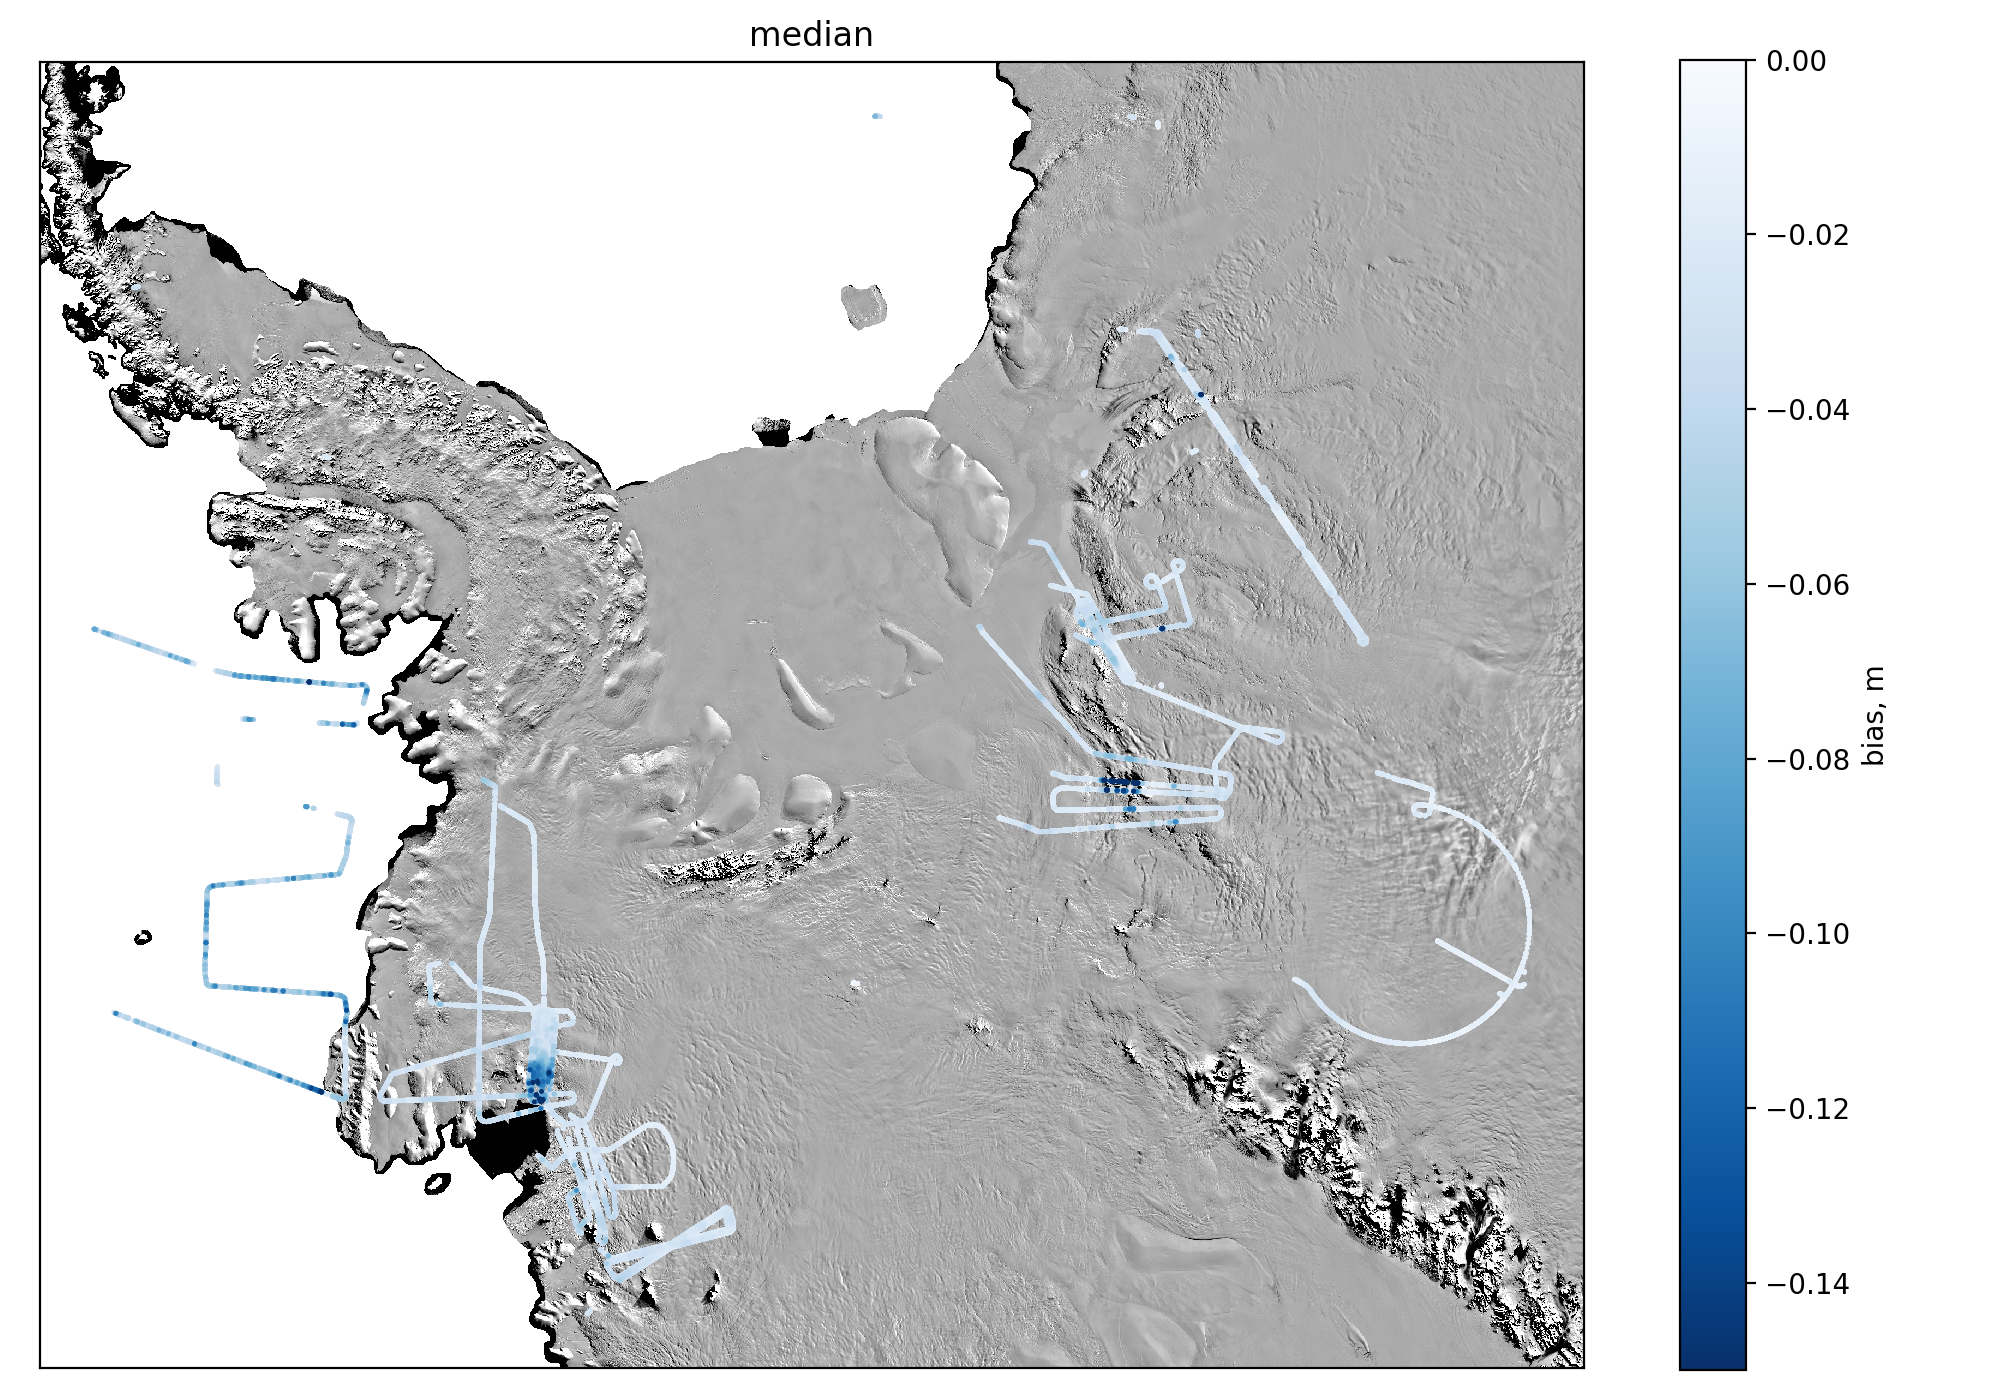

{'clim': [14000, 17000], 'cmap': 'gray', 'extent': array([-2511950.,   319050.,  -813175.,  1579825.]), 'origin': 'lower'}


In [9]:
plt.figure(figsize=[10, 7]); 

MOA_1km.show(clim=[14000, 17000], cmap='gray')
ii=np.argsort(D.t_med)[::2]
plt.scatter(D.x[ii], D.y[ii], 3,  c=(D.t_med[ii]-t_tx_med)*-.15, linewidth=0, cmap='Blues_r', vmin=-0.15, vmax=0); 
plt.title('median')
hb=plt.colorbar()
hb.set_label('bias, m')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()

In [10]:
x0=-1.593e6
y0=-2.7e5
W=200e3
pad=np.array([-W/2, W/2])
MOA_hi=pc.grid.data().from_geotif(MOA_125_file, bounds=(x0+pad, y0+pad))


<IPython.core.display.Javascript object>


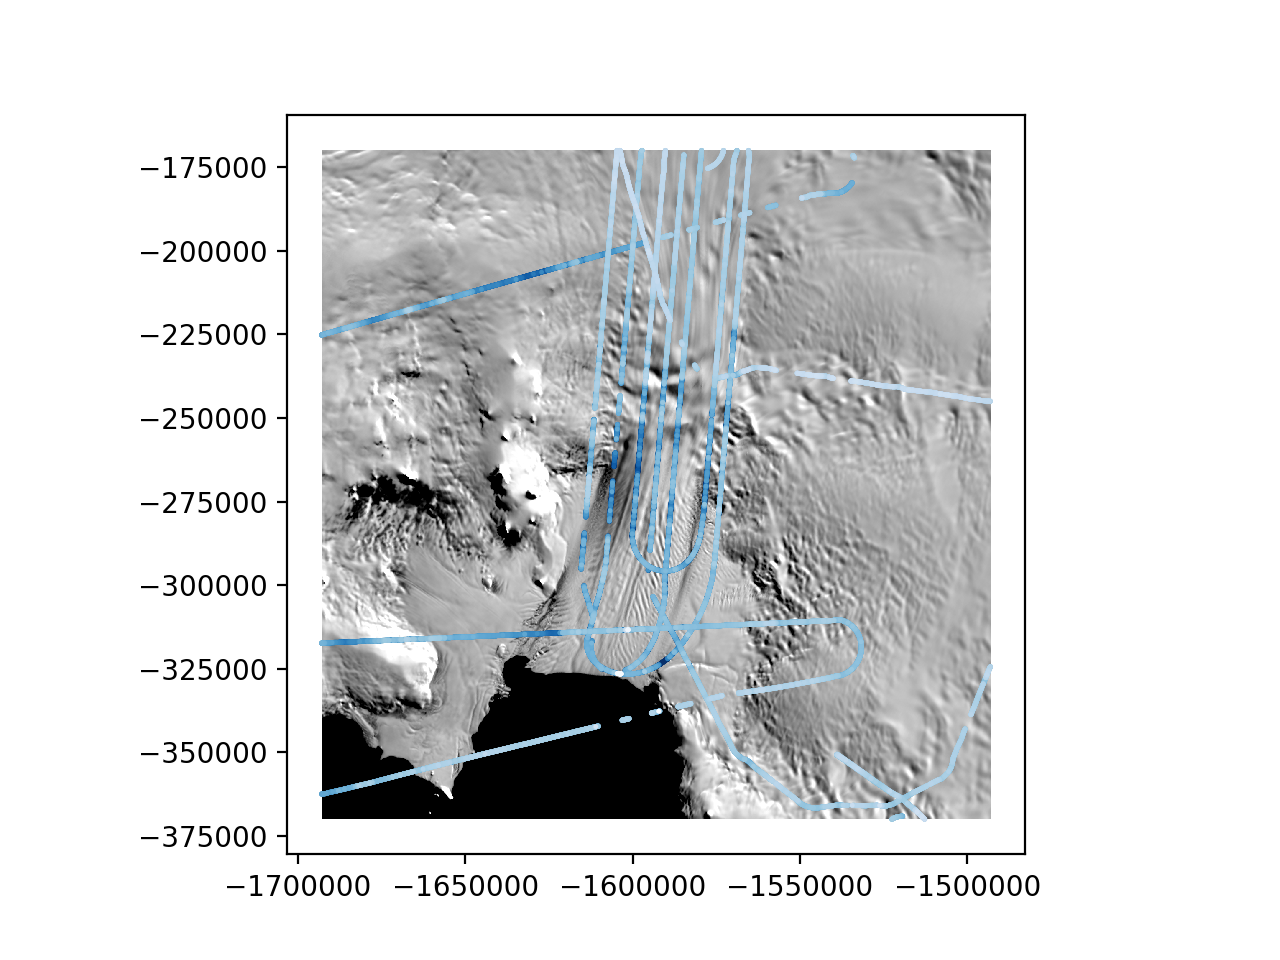

{'clim': [14000, 17000], 'cmap': 'gray', 'extent': array([-1692887.5, -1493012.5,  -369987.5,  -170112.5]), 'origin': 'lower'}


In [11]:

fig=plt.figure();
plt.clf()
ax=fig.add_subplot(1,1,1)
els=(D.x >x0-W/2) & (D.x < x0+W/2) & (D.y >y0-W/2) & (D.y < y0+W/2)
Dsub=D[els]
MOA_hi.show(clim=[14000, 17000], cmap='gray')
bias=(Dsub.t_med-t_tx_med)*-.15
ii=np.argsort(bias)
plt.scatter(Dsub.x[ii], Dsub.y[ii],3, c=bias[ii], linewidth=0, cmap='Blues_r', vmin=-0.05, vmax=0); 


In [12]:
xr=plt.gca().get_xlim()
yr=plt.gca().get_ylim()
els=(D.x > xr[0]) & (D.x < xr[1]) & (D.y > yr[0]) & (D.y < yr[1])
file_nums=np.unique(D.file_number[els])
print(np.unique(D.file_number[els]))



[   2.    3.    5.    6.    7.   10.   11.   12.   14.   15.   19.   20.
   22.   23.   24.   27.   28.   29.   30.   31.   32.   36.   37.   38.
   40.   42.   43.   44.   45.   46.   48.   49.   50.   51.   52.   53.
   56.   57.   58.   60.   61.   63.   65.   66.   67.   68.   69.   70.
   71.   72.   73.   74.   76.   77.   78.   79.   80.   81.   82.   83.
   85.   86.   87.   88.   89.   90.   92.   94.   96.   97.   98.   99.
  100.  102.  103.  104.  106.  108.  109.  111.  113.  114.  115.  118.
  119.  122.  123.  124.  126.  127.  129.  130.  131.  132.  134.  135.
  136.  139.  140.  141.  142.  144.  145.  146.  147.  149.  150.  153.
  154.  155.  156.  157.  158.  159.  162.  163.  164.  165.  167.  169.
  170.  171.  172.  173.  174.  175.  178.  179.  183.  184.  186.  187.
  190.  191.  192.  194.  195.  196.  200.  201.  202.  203.  204.  210.
  211.  212.  214.  215.  216.  219.  220.  222.  223.  226.  227.  230.
  231.  232.  234.  236.  239.  240.  241.  242.  2

<IPython.core.display.Javascript object>


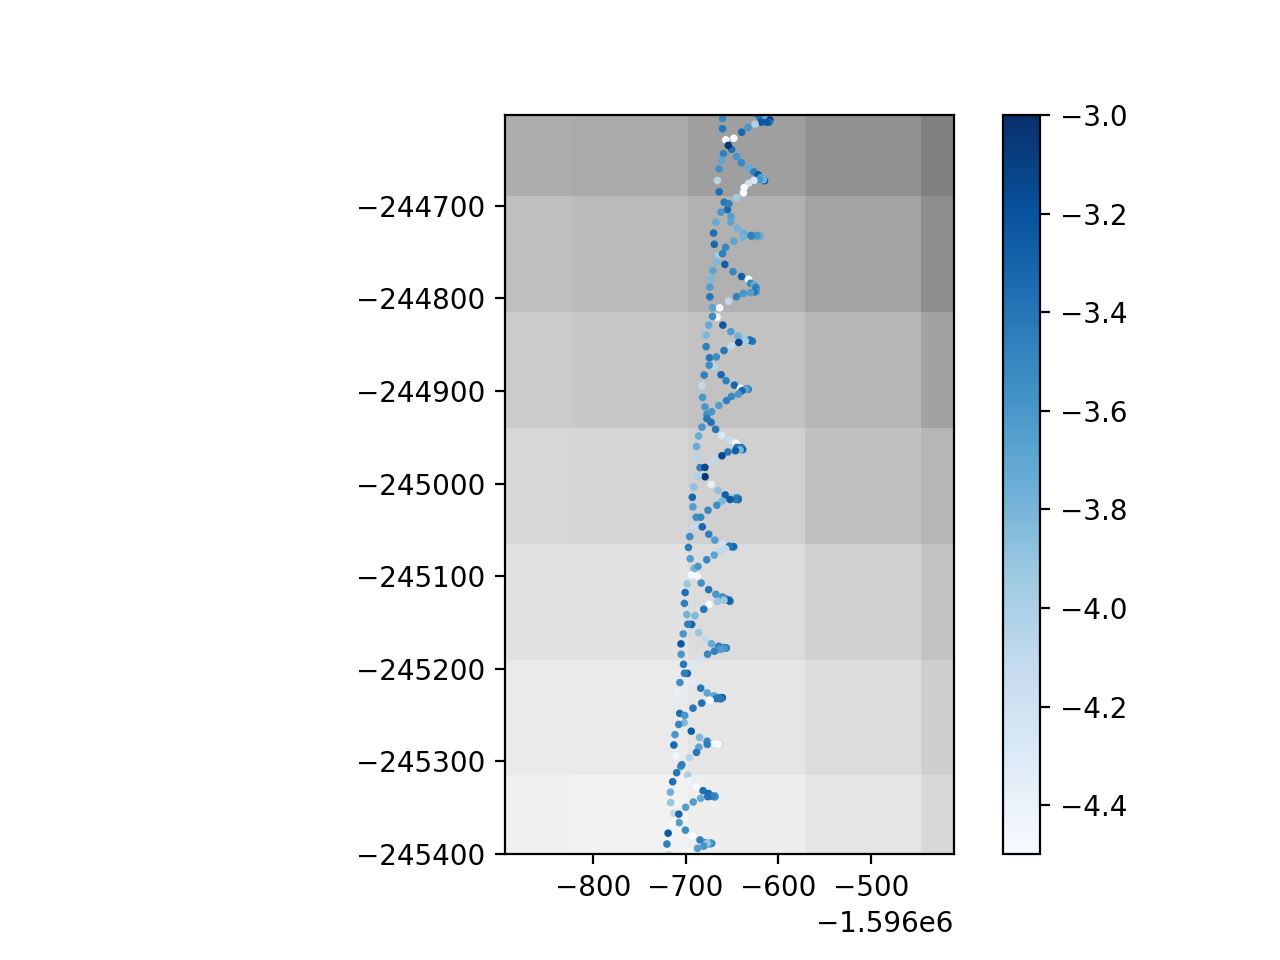

{'cmap': 'gray', 'vmin': 14000, 'vmax': 17000, 'extent': array([-1692887.5, -1493012.5,  -369987.5,  -170112.5]), 'origin': 'lower'}


In [20]:
plt.figure(12); plt.clf() 
MOA_hi.show(cmap='gray', vmin=14000, vmax=17000)
plt.scatter(D_all.x[::50], D_all.y[::50], 3, c=D_all.A[::50], vmin=100, vmax=250)


<IPython.core.display.Javascript object>


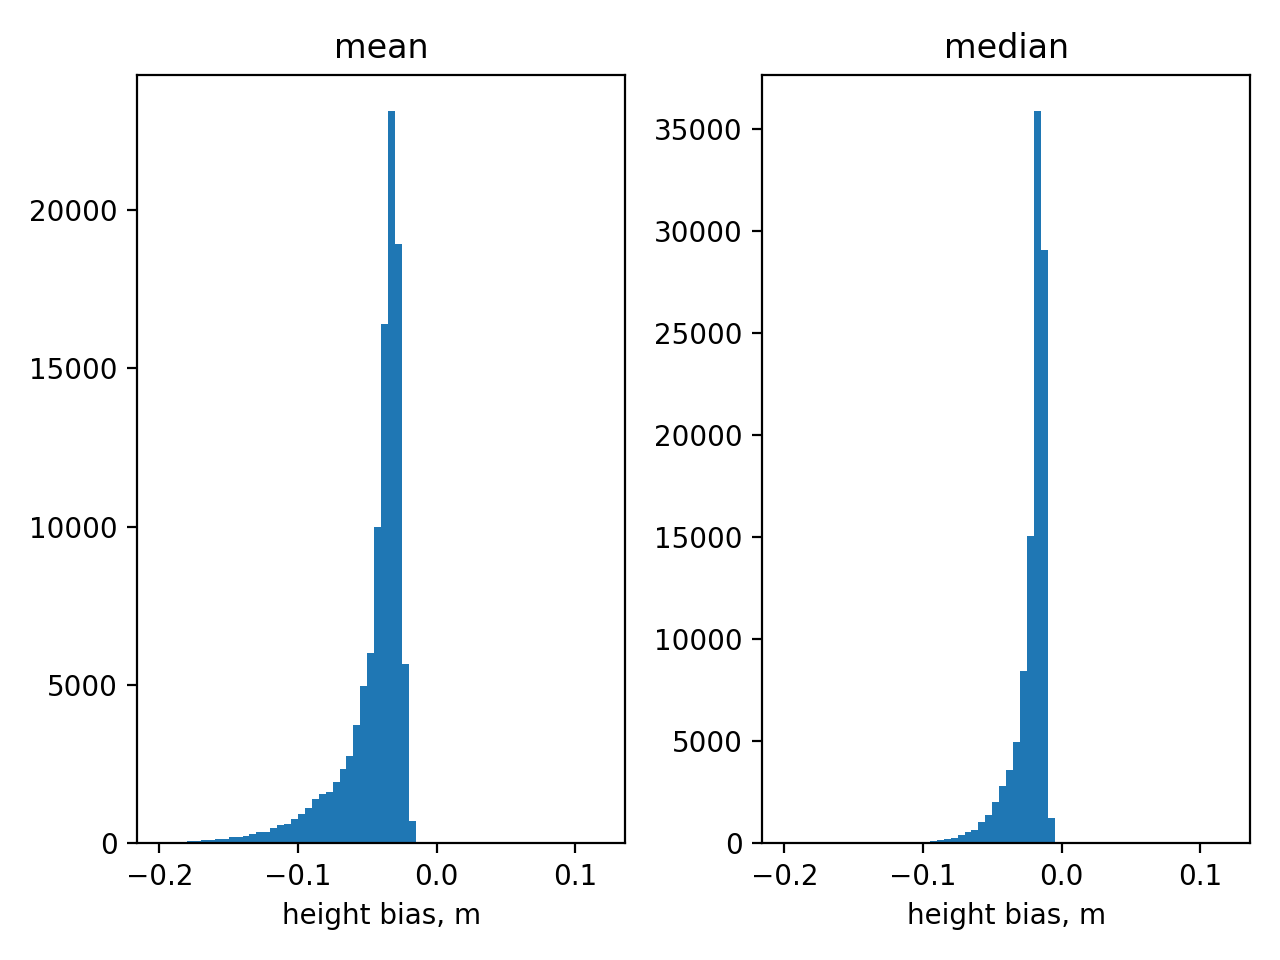

In [19]:
plt.figure(); plt.gcf().add_subplot(121); 
plt.hist((D.t_ctr[ii]-t_tx_mean)*-.15, np.arange(-0.2, 0.125, 0.005))
plt.title('mean')
plt.xlabel('height bias, m')
plt.gcf().add_subplot(122); 
plt.hist((D.t_med[ii]-t_tx_med)*-.15, np.arange(-0.2, 0.125, 0.005))
plt.title('median')
plt.xlabel('height bias, m')
plt.tight_layout()

In [22]:
plt.figure(12); plt.clf() 
MOA_hi.show(cmap='gray', vmin=14000, vmax=17000)

D_all.index(D_all.K0>0)
plt.scatter(D_all.x[::50], D_all.y[::50], 3, c=np.log10(D_all.K0[::50]), vmin=-4.5, vmax=-3, cmap='Blues'); plt.colorbar()

{'cmap': 'gray', 'vmin': 14000, 'vmax': 17000, 'extent': array([-1692887.5, -1493012.5,  -369987.5,  -170112.5]), 'origin': 'lower'}


In [23]:
D

<class 'pointCollection.data.data'> with shape (997273,),
with fields:
['t_med', 'file_number', 'y', 'z_sigma', 't_sigma', 'x', 't_ctr']